In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from utils.loadData import *
from utils.tools import *
from cnn.resnet import *

定义残差块，注释部分尝试用英语写一下，嘿嘿。

In [2]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        # one of the difference between conv1 and conv2 is the first channel number
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        # another difference is that we need to halve the width and depth when 
        # the input_channels is not equal to the num_channels
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        # residual block connects the x and y, but both of them have different dims
        # use_1x1conv is the option B mentioned in the paper increasing the computation complex
        # usually used by adding the dimension of x
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        # remember to return relu(Y)
        return F.relu(Y)

测试1：假设输入残差块的通道数 = 输出残差块的通道数

In [3]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

测试2：假设输入通道数 < 输出通道数

In [4]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

定义一个 resnet-34 模型：
1. 首先使用了一个 7x7 卷积.图像高宽减半
2. 随后使用了一个 maxpooling.图像高宽减半

In [5]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

3. 自定义的残差块堆叠

In [6]:
# we keep the input width, height and channels identical from the first block
# because b1 has already made the input halved twice.
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 3, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 4))
b4 = nn.Sequential(*resnet_block(128, 256, 6))
b5 = nn.Sequential(*resnet_block(256, 512, 3))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

观察一下ResNet中不同模块的输入形状是如何变化的

In [7]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


训练模型

loss 0.001, train acc 1.000, test acc 0.813
629.2 examples/sec on cuda:0


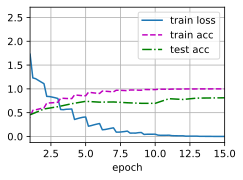

In [8]:
lr, num_epochs, batch_size = 0.05, 15, 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [ ]:
net = get_resnet50()
lr, num_epochs, batch_size = 0.05, 15, 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())